In [1]:
## Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
#import regionmask
#from ComputeLCLpressure_function import ComputeLCLpressure

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


In [2]:
## Function from Brian Medeiros to convert times to middle of period 
#  rather than the end of the averaging period. 

def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


**Set up colormaps for plotting CI**

In [3]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    import matplotlib as mpl
    import numpy as np
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap


In [4]:
### Create a list of RGB tuples for terrestrial leg (SM, SHFLX)
colorsList_SMvSHF = [(124,135,181), 
                     (107,109,161),
                     (51,82,120),
                     (49,114,127),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58)] # This example uses the 8-bit RGB

my_cmap_SMvSHF = make_cmap(colorsList_SMvSHF, bit=True)


### Create a list of RGB tuples for atmospheric leg (SHFLX, P_lcl)
colorsList_SHFvPlcl = [(172,183,209), 
                     (124,135,181),
                     (51,82,120),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58),
                     (136,90,59),
                     (214,48,44),
                     (224,93,126),
                     (242,189,177)] # This example uses the 8-bit RGB

my_cmap_SHFvPlcl = make_cmap(colorsList_SHFvPlcl, bit=True)



## Read in data

Read in CESM2 data along with CLM4.5+CAM6 data (extended period, so from two different code bases - but in hindsight, that'll be the case regardless since the original CESM2 data is from the CMIP runs).
<br><br>
**BUT**, if we use Isla's CAM6+CLM5 and CAM6+CLM4.5 runs, which have a lot higher resolution data too, then this can totally work and be more consistent. But as a first test, let's look at just pulling daily TREFHT, TREFHTMX, and TREFHTMN from each of her runs and assume that the CI changes should be roughly consistent. 

In [5]:
# Load in pickle files: 
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'

## Read in CESM2 data ( CAM6 + CLM5 )

file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_1979-2006.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_1979-2006.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_1979-2006.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CAM6wCLM5  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CAM6wCLM5 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CAM6wCLM5  = xr.open_dataset(dataDir+file_LH,      decode_times=False)

lat = atmoLeg_CAM6wCLM5.lat.values
lon = atmoLeg_CAM6wCLM5.lon.values


In [6]:
## Read in CAM6 + CLM4.5 data 
file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CESM2-CLM45.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CESM2-CLM45.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CESM2-CLM45.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CAM6wCLM45  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CAM6wCLM45 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CAM6wCLM45  = xr.open_dataset(dataDir+file_LH,      decode_times=False)


## What do the differences in coupling index look like between the two runs?

In [7]:
# --- Define array of colors for maps --- #

# Isolate seasonal arrays (seasons go: DJF,JJA,MAM,SON)
AtmoLeg_JJA_cesm2  = np.squeeze(np.asarray(atmoLeg_CAM6wCLM5.hfss_Plcl_CI[1,:,:]))
TerraLeg_JJA_cesm2 = np.squeeze(np.asarray(terraLeg_CAM6wCLM5.mrsos_hfss_CI[1,:,:]))

AtmoLeg_JJA_clm45  = np.squeeze(np.asarray(atmoLeg_CAM6wCLM45.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm45 = np.squeeze(np.asarray(terraLeg_CAM6wCLM45.soilM_10_SHFLX_CI[1,:,:]))

# Make cyclic first 
AtmoLeg_JJA_cyclic_cesm2, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA_cesm2, lon)
TerraLeg_JJA_cyclic_cesm2, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_cesm2, lon)
AtmoLeg_JJA_cyclic_clm45, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA_clm45, lon)
TerraLeg_JJA_cyclic_clm45, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_clm45, lon)

# Now get color coded arrays 
colorsAtmoLeg_cesm2  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cesm2 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_clm45  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_clm45 = np.full([len(lat),len(lon)+1],np.nan)


# ----- CESM 2 ------

# Atmo leg 
colorsAtmoLeg_cesm2[np.where(AtmoLeg_JJA_cyclic_cesm2<-150)]                                 = 1
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-150) & (AtmoLeg_JJA_cyclic_cesm2<=-100))]  = 2
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-100) & (AtmoLeg_JJA_cyclic_cesm2<=-50))]   = 3
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-50)  & (AtmoLeg_JJA_cyclic_cesm2<=-20))]   = 4
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-20)  & (AtmoLeg_JJA_cyclic_cesm2<=0))]     = 5
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>0)    & (AtmoLeg_JJA_cyclic_cesm2<=20))]    = 6
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>20)   & (AtmoLeg_JJA_cyclic_cesm2<=40))]    = 7
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>40)   & (AtmoLeg_JJA_cyclic_cesm2<=60))]    = 8
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>60)   & (AtmoLeg_JJA_cyclic_cesm2<=80))]    = 9
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>80)   & (AtmoLeg_JJA_cyclic_cesm2<=100))]   = 10
colorsAtmoLeg_cesm2[np.where(AtmoLeg_JJA_cyclic_cesm2>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cesm2[np.where(TerraLeg_JJA_cyclic_cesm2<-20)]                                 = 1
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-20) & (TerraLeg_JJA_cyclic_cesm2<=-15))]  = 2
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-15) & (TerraLeg_JJA_cyclic_cesm2<=-10))]  = 3
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-10) & (TerraLeg_JJA_cyclic_cesm2<=-5))]   = 4
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-5) & (TerraLeg_JJA_cyclic_cesm2<=-2))]    = 5
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-2) & (TerraLeg_JJA_cyclic_cesm2<=-1))]    = 6
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-1) & (TerraLeg_JJA_cyclic_cesm2<=0))]     = 7
colorsTerraLeg_cesm2[np.where(TerraLeg_JJA_cyclic_cesm2>0)]                                   = 8



# ----- CLM4.5 ------

# Atmo leg 
colorsAtmoLeg_clm45[np.where(AtmoLeg_JJA_cyclic_clm45<-150)]                                 = 1
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-150) & (AtmoLeg_JJA_cyclic_clm45<=-100))]  = 2
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-100) & (AtmoLeg_JJA_cyclic_clm45<=-50))]   = 3
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-50)  & (AtmoLeg_JJA_cyclic_clm45<=-20))]   = 4
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-20)  & (AtmoLeg_JJA_cyclic_clm45<=0))]     = 5
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>0)    & (AtmoLeg_JJA_cyclic_clm45<=20))]    = 6
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>20)   & (AtmoLeg_JJA_cyclic_clm45<=40))]    = 7
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>40)   & (AtmoLeg_JJA_cyclic_clm45<=60))]    = 8
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>60)   & (AtmoLeg_JJA_cyclic_clm45<=80))]    = 9
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>80)   & (AtmoLeg_JJA_cyclic_clm45<=100))]   = 10
colorsAtmoLeg_clm45[np.where(AtmoLeg_JJA_cyclic_clm45>100)]                                  = 11


# Terra leg  
colorsTerraLeg_clm45[np.where(TerraLeg_JJA_cyclic_clm45<-20)]                                 = 1
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-20) & (TerraLeg_JJA_cyclic_clm45<=-15))]  = 2
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-15) & (TerraLeg_JJA_cyclic_clm45<=-10))]  = 3
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-10) & (TerraLeg_JJA_cyclic_clm45<=-5))]   = 4
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-5) & (TerraLeg_JJA_cyclic_clm45<=-2))]    = 5
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-2) & (TerraLeg_JJA_cyclic_clm45<=-1))]    = 6
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-1) & (TerraLeg_JJA_cyclic_clm45<=0))]     = 7
colorsTerraLeg_clm45[np.where(TerraLeg_JJA_cyclic_clm45>0)]                                   = 8


In [8]:
# -- Make land mask to ignore anything that's not over land -- # 
lndMask = np.full([len(lat),len(lon)+1],np.nan)
lndMask[np.where(np.isfinite(TerraLeg_JJA_cyclic_cesm2))] = 1

lndMask_notCyclic = np.full([len(lat),len(lon)],np.nan)
lndMask_notCyclic[np.where(np.isfinite(TerraLeg_JJA_cesm2))] = 1



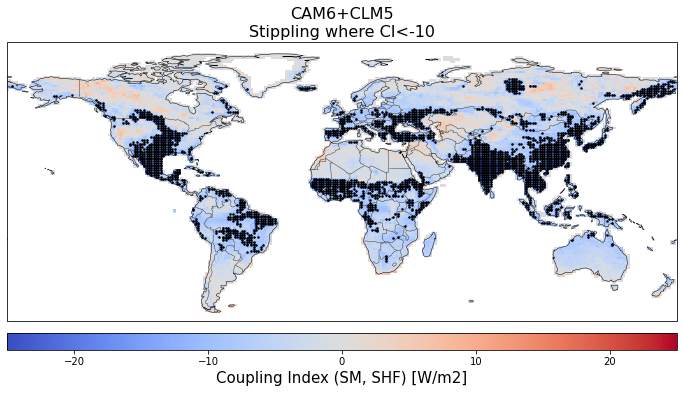

In [35]:
# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})



# ----- Plot CESM2 panels ------ 
# Set global-ish extent
ax1.set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = ax1.pcolormesh(lon_cyclic,lat,TerraLeg_JJA_cyclic_cesm2,
                             cmap='coolwarm',
                             vmin=-25,vmax=25)
for ilat in range(len(lat)):
    for ilon in range(len(lon_cyclic)):
        if TerraLeg_JJA_cyclic_cesm2[ilat,ilon]<-10:
            ax1.plot(lon_cyclic[ilon],lat[ilat],'.',color='k',markersize=3,transform=ccrs.PlateCarree())

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=15)


# Additional options 
ax1.set_title('CAM6+CLM5\nStippling where CI<-10',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


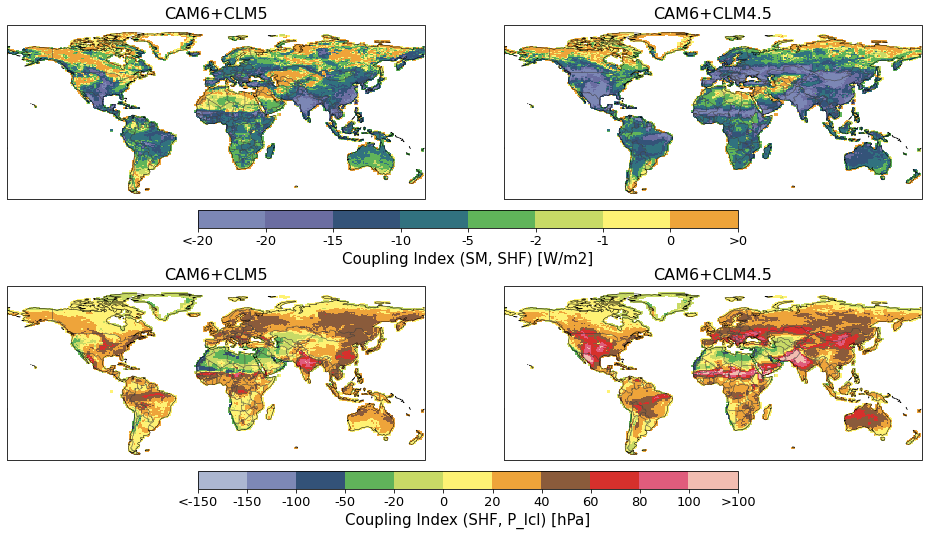

In [9]:
# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.5,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm2,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm2*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[0].set_title('CAM6+CLM5',fontsize=16)
axs[2].set_title('CAM6+CLM5',fontsize=16)
# axs[0].gridlines()
# axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CAM6+CLM4.5 panels ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,colorsTerraLeg_clm45,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.25, ax_position.y0-0.05, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=15)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=13)  # vertically oriented colorbar


bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[3].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_clm45*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)
# Add colorbar 
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.25, ax_position.y0-0.05, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SHF, P_lcl) [hPa]',fontsize=15)
cbar.ax.set_xticklabels(['<-150','-150','-100','-50','-20','0','20','40','60','80','100','>100'],fontsize=13)  # vertically oriented colorbar


# Additional options 
axs[1].set_title('CAM6+CLM4.5',fontsize=16)
axs[3].set_title('CAM6+CLM4.5',fontsize=16)
# axs[1].gridlines()
# axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




In [9]:
atmoDiff_CESM2vCLM45  = AtmoLeg_JJA_cyclic_cesm2 - AtmoLeg_JJA_cyclic_clm45  # Impact of upgrading CLM 
terraDiff_CESM2vCLM45 = TerraLeg_JJA_cyclic_cesm2 - TerraLeg_JJA_cyclic_clm45 # Impact of upgrading CLM 


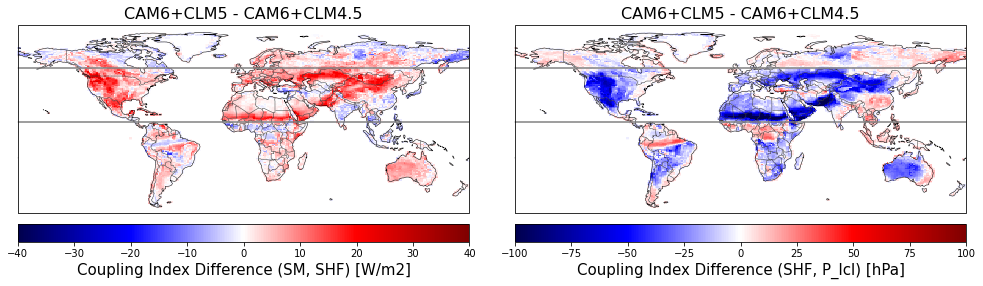

In [68]:
# Set up figure 
fig, axs = plt.subplots(1,2, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.5,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCLM45,
                             vmax = 40, vmin = -40,
                             cmap='seismic')
# Add colorbars 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Coupling Index Difference (SM, SHF) [W/m2]',fontsize=15)


contour_plot = axs[1].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCLM45*lndMask,
                                 vmax = 100, vmin = -100,
                             cmap='seismic')


# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Coupling Index Difference (SHF, P_lcl) [hPa]',fontsize=15)


# Additional options 
axs[0].set_title('CAM6+CLM5 - CAM6+CLM4.5',fontsize=16)
axs[1].set_title('CAM6+CLM5 - CAM6+CLM4.5',fontsize=16)
# axs[0].gridlines()
# axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


## Add lat lines...
axs[0].axhline(12, color='grey')
axs[1].axhline(12, color='grey')
axs[0].axhline(55, color='grey')
axs[1].axhline(55, color='grey')


# # Additional options 
# axs[1].set_title('CAM6+CLM4.5',fontsize=16)
# axs[3].set_title('CAM6+CLM4.5',fontsize=16)
# # axs[1].gridlines()
# # axs[5].gridlines()
# axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
# axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
# axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
# axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')





## Now what do other variables look like?

In [10]:
## Read in TREFHT variables and PRECT (and merge into single dataset)

dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/day/'

CLM5file  = dataDir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001.cam.h1.1980-2009_TREFHTs.nc'
CLM45file = dataDir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm4p5.001.cam.h1.1980-2009_TREFHTs.nc'

with xr.open_dataset(CLM5file, decode_times=False) as trefCLM5_DS: 
    trefCLM5_DS = cesm_correct_time(trefCLM5_DS)
    
with xr.open_dataset(CLM45file, decode_times=False) as trefCLM45_DS: 
    trefCLM45_DS = cesm_correct_time(trefCLM45_DS)
    


In [11]:
CLM5file  = dataDir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001.cam.h1.1980-2009_PRECT.nc'
CLM45file = dataDir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm4p5.001.cam.h1.1980-2009_PRECT.nc'

with xr.open_dataset(CLM5file, decode_times=False) as prectCLM5_DS: 
    prectCLM5_DS = cesm_correct_time(prectCLM5_DS)
    
with xr.open_dataset(CLM45file, decode_times=False) as prectCLM45_DS: 
    prectCLM45_DS = cesm_correct_time(prectCLM45_DS)
    

In [12]:
# Merge datasets 
clm5_DS  = xr.merge([trefCLM5_DS, prectCLM5_DS])
clm45_DS = xr.merge([trefCLM45_DS, prectCLM45_DS])


In [13]:
## Select just JJA for each point 

iJJA_CLM5  = np.where((clm5_DS.indexes['time'].month>=6) & (clm5_DS.indexes['time'].month<=8))[0]
iJJA_CLM45 = np.where((clm45_DS.indexes['time'].month>=6) & (clm45_DS.indexes['time'].month<=8))[0]

clm5_DS  = clm5_DS.isel(time=iJJA_CLM5)
clm45_DS = clm45_DS.isel(time=iJJA_CLM45)



In [14]:
## Remove daily climatology from each point 
month_day_idx               = pd.MultiIndex.from_arrays([clm5_DS['time.month'].values, clm5_DS['time.day'].values])
clm5_DS.coords['month_day'] = ('time', month_day_idx)
clm5_DS_anomalies           = clm5_DS.groupby('month_day') - clm5_DS.groupby('month_day').mean()

month_day_idx                = pd.MultiIndex.from_arrays([clm45_DS['time.month'].values, clm45_DS['time.day'].values])
clm45_DS.coords['month_day'] = ('time', month_day_idx)
clm45_DS_anomalies           = clm45_DS.groupby('month_day') - clm45_DS.groupby('month_day').mean()


Text(0, 0.5, 'TREFHT Anomalies (K)')

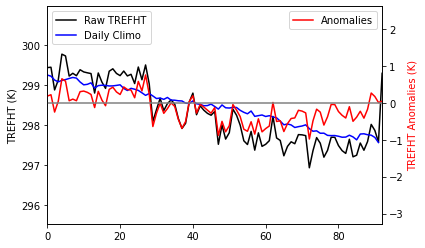

In [37]:
## Sanity check that removing the daily climatology worked how I thought it would
#     Spoiler alert: it looks like it did! :) 

# testDS = clm5_DS.groupby('month_day') - clm5_DS_monthly
clm5_DS_monthly = clm5_DS.groupby('month_day').mean()

plt.plot(clm5_DS.TREFHT.values[:,100,200],'k',label='Raw TREFHT')
plt.xlim([0,92])
plt.plot(clm5_DS_monthly.TREFHT.values[:,100,200],'b', label='Daily Climo')
plt.legend(loc = 'upper left')
plt.ylabel('TREFHT (K)')

ax2 = plt.twinx()
ax2.plot(clm5_DS_anomalies.TREFHT.values[:,100,200],'r',label='Anomalies')
ax2.axhline(0,color='grey')
ax2.legend(loc='upper right')
ax2.set_ylabel('TREFHT Anomalies (K)',color='r')


In [15]:
## Get XXth percentile values per location 

qt_dims   = ("time")
qt_values = (0.9, 0.95, 0.99)

clm5_DS_qt = clm5_DS_anomalies.quantile(qt_values, dim=qt_dims, 
                                           interpolation='linear',
                                           keep_attrs=True, skipna=True)

clm45_DS_qt = clm45_DS_anomalies.quantile(qt_values, dim=qt_dims, 
                                           interpolation='linear',
                                           keep_attrs=True, skipna=True)


In [50]:
## Get XXth percentile values per location for raw values, not anomalies

qt_dims   = ("time")
qt_values = (0.9, 0.95, 0.99)

clm5_DSnoAnom_qt = clm5_DS.drop('time_bnds').quantile(qt_values, dim=qt_dims, 
                                           interpolation='linear',
                                           keep_attrs=True, skipna=True)

clm45_DSnoAnom_qt = clm45_DS.drop('time_bnds').quantile(qt_values, dim=qt_dims, 
                                           interpolation='linear',
                                           keep_attrs=True, skipna=True)


In [51]:
# How many days exist above those percentiles?
i90 = np.where(clm45_DS_anomalies.TREFHT.values[:,100,200] >= clm45_DS_qt.TREFHT.values[0,100,200])[0]
print('Number of days above 90th percentile: ', len(i90))

i95 = np.where(clm45_DS_anomalies.TREFHT.values[:,100,200] >= clm45_DS_qt.TREFHT.values[1,100,200])[0]
print('Number of days above 95th percentile: ', len(i95))

i99 = np.where(clm45_DS_anomalies.TREFHT.values[:,100,200] >= clm45_DS_qt.TREFHT.values[2,100,200])[0]
print('Number of days above 99th percentile: ', len(i99))



Number of days above 90th percentile:  277
Number of days above 95th percentile:  138
Number of days above 99th percentile:  28


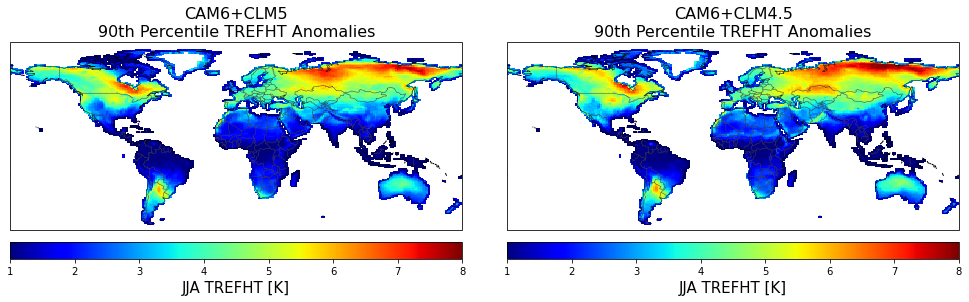

In [99]:
# Set up figure 
fig, axs = plt.subplots(1,2, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.5,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,clm5_DS_qt.TREFHT.values[0,:,:]*lndMask_notCyclic,
                                 vmin = 1, vmax = 8, 
                                 cmap='jet')
# Add colorbars 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA TREFHT [K]',fontsize=15)


contour_plot = axs[1].pcolormesh(lon,lat,clm45_DS_qt.TREFHT.values[0,:,:]*lndMask_notCyclic,
                                 vmin = 1, vmax = 8,
                                 cmap='jet')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA TREFHT [K]',fontsize=15)


# Additional options 
axs[0].set_title('CAM6+CLM5\n90th Percentile TREFHT Anomalies',fontsize=16)
axs[1].set_title('CAM6+CLM4.5\n90th Percentile TREFHT Anomalies',fontsize=16)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



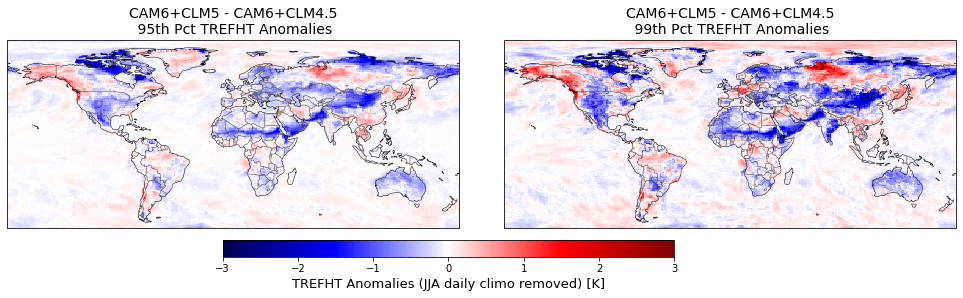

In [107]:
# Set up figure 
fig, axs = plt.subplots(1,2, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.5,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,clm5_DS_qt.TREFHT.values[1,:,:] - clm45_DS_qt.TREFHT.values[1,:,:],
                             vmax = 3, vmin = -3,
                             cmap='seismic')

contour_plot = axs[1].pcolormesh(lon,lat,clm5_DS_qt.TREFHT.values[2,:,:] - clm45_DS_qt.TREFHT.values[2,:,:],
                                 vmax = 3, vmin = -3,
                             cmap='seismic')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.23, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('TREFHT Anomalies (JJA daily climo removed) [K]',fontsize=13)

# Additional options 
axs[0].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 95th Pct TREFHT Anomalies',fontsize=14)
axs[1].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 99th Pct TREFHT Anomalies',fontsize=14)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


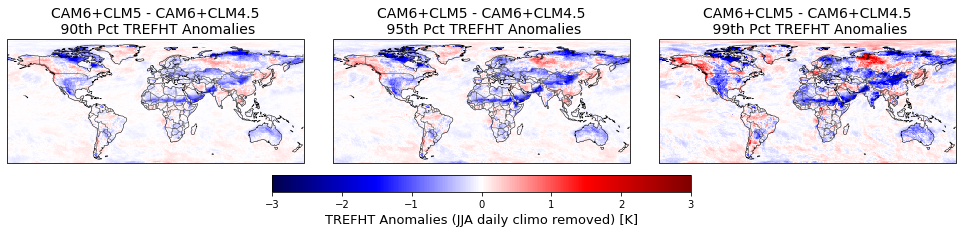

In [96]:
# Set up figure 
fig, axs = plt.subplots(1,3, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.5,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,clm5_DS_qt.TREFHT.values[0,:,:] - clm45_DS_qt.TREFHT.values[0,:,:],
                             vmax = 3, vmin = -3,
                             cmap='seismic')

contour_plot = axs[1].pcolormesh(lon,lat,clm5_DS_qt.TREFHT.values[1,:,:] - clm45_DS_qt.TREFHT.values[1,:,:],
                                 vmax = 3, vmin = -3,
                             cmap='seismic')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.05, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('TREFHT Anomalies (JJA daily climo removed) [K]',fontsize=13)

contour_plot = axs[2].pcolormesh(lon,lat,clm5_DS_qt.TREFHT.values[2,:,:] - clm45_DS_qt.TREFHT.values[2,:,:],
                                 vmax = 3, vmin = -3,
                             cmap='seismic')


# Additional options 
axs[0].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 90th Pct TREFHT Anomalies',fontsize=14)
axs[1].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 95th Pct TREFHT Anomalies',fontsize=14)
axs[2].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 99th Pct TREFHT Anomalies',fontsize=14)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



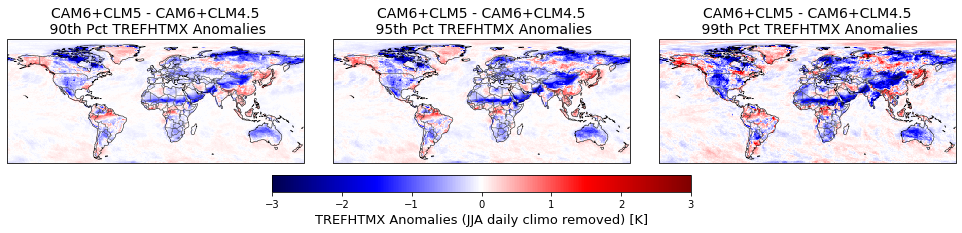

In [113]:
# Set up figure 
fig, axs = plt.subplots(1,3, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.5,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,clm5_DS_qt.TREFHTMX.values[0,:,:] - clm45_DS_qt.TREFHTMX.values[0,:,:],
                             vmax = 3, vmin = -3,
                             cmap='seismic')

contour_plot = axs[1].pcolormesh(lon,lat,clm5_DS_qt.TREFHTMX.values[1,:,:] - clm45_DS_qt.TREFHTMX.values[1,:,:],
                                 vmax = 3, vmin = -3,
                             cmap='seismic')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.05, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('TREFHTMX Anomalies (JJA daily climo removed) [K]',fontsize=13)

contour_plot = axs[2].pcolormesh(lon,lat,clm5_DS_qt.TREFHTMX.values[2,:,:] - clm45_DS_qt.TREFHTMX.values[2,:,:],
                                 vmax = 3, vmin = -3,
                             cmap='seismic')


# Additional options 
axs[0].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 90th Pct TREFHTMX Anomalies',fontsize=14)
axs[1].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 95th Pct TREFHTMX Anomalies',fontsize=14)
axs[2].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 99th Pct TREFHTMX Anomalies',fontsize=14)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




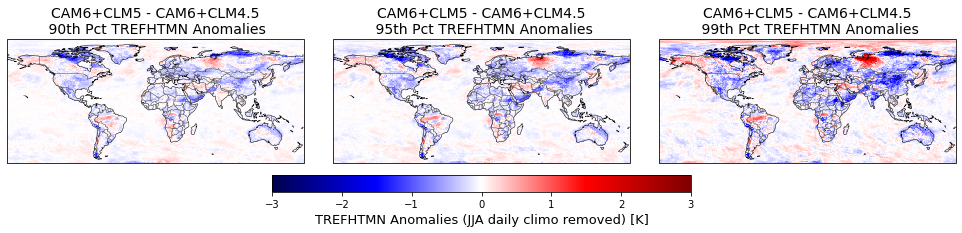

In [114]:
# Set up figure 
fig, axs = plt.subplots(1,3, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.5,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,clm5_DS_qt.TREFHTMN.values[0,:,:] - clm45_DS_qt.TREFHTMN.values[0,:,:],
                             vmax = 3, vmin = -3,
                             cmap='seismic')

contour_plot = axs[1].pcolormesh(lon,lat,clm5_DS_qt.TREFHTMN.values[1,:,:] - clm45_DS_qt.TREFHTMN.values[1,:,:],
                                 vmax = 3, vmin = -3,
                             cmap='seismic')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.05, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('TREFHTMN Anomalies (JJA daily climo removed) [K]',fontsize=13)

contour_plot = axs[2].pcolormesh(lon,lat,clm5_DS_qt.TREFHTMN.values[2,:,:] - clm45_DS_qt.TREFHTMN.values[2,:,:],
                                 vmax = 3, vmin = -3,
                             cmap='seismic')


# Additional options 
axs[0].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 90th Pct TREFHTMN Anomalies',fontsize=14)
axs[1].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 95th Pct TREFHTMN Anomalies',fontsize=14)
axs[2].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 99th Pct TREFHTMN Anomalies',fontsize=14)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


#### Distributions??

In [75]:
# Get mid-latitude values only 
ilat = np.where((lat>=12) & (lat<=55))[0]
clm5_DS_anomalies_midLat  = clm5_DS_anomalies.isel(lat=ilat)
clm45_DS_anomalies_midLat = clm45_DS_anomalies.isel(lat=ilat)


In [78]:
lndTREFHT_clm5  = clm5_DS_anomalies_midLat.TREFHT.values*lndMask_notCyclic[ilat,:]
lndTREFHT_clm45 = clm45_DS_anomalies_midLat.TREFHT.values*lndMask_notCyclic[ilat,:]


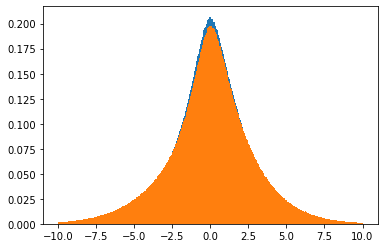

In [80]:
binEdges = np.linspace(-10,10,1000)

histCLM5  = plt.hist(lndTREFHT_clm5.reshape([len(lat[ilat])*len(lon)*np.shape(lndTREFHT_clm5)[0]]), bins=binEdges, density=True)
histCLM45 = plt.hist(lndTREFHT_clm45.reshape([len(lat[ilat])*len(lon)*np.shape(lndTREFHT_clm45)[0]]), bins=binEdges, density=True)

plt.show()


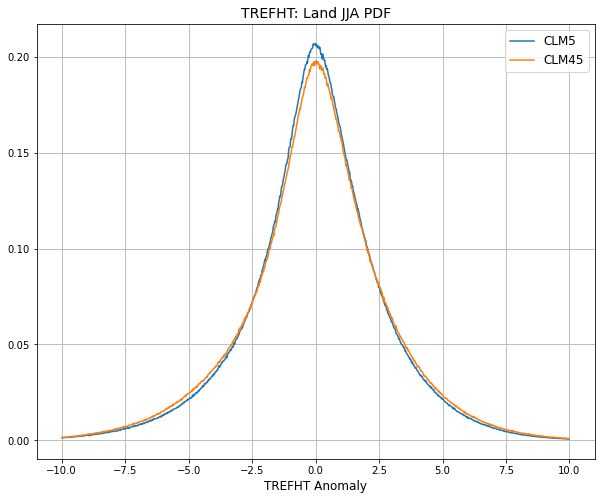

In [81]:
binWidth  = (binEdges[1]-binEdges[0])/2
binCenters = binEdges[1::]-binWidth

fig, ax1 = plt.subplots(1,1, figsize=(10, 8))

ax1.plot(binCenters, histCLM5[0], label='CLM5')
ax1.plot(binCenters, histCLM45[0], label='CLM45')

ax1.set_title('TREFHT: Land JJA PDF',fontsize=14)
ax1.legend(fontsize=12)
ax1.set_xlabel('TREFHT Anomaly',fontsize=12)
ax1.grid()


In [44]:
lndPRECT_clm5  = clm5_DS.PRECT.values*lndMask_notCyclic
lndPRECT_clm45 = clm45_DS.PRECT.values*lndMask_notCyclic

In [54]:
np.nanmean(lndPRECT_clm5)

2.9597211760470906e-08

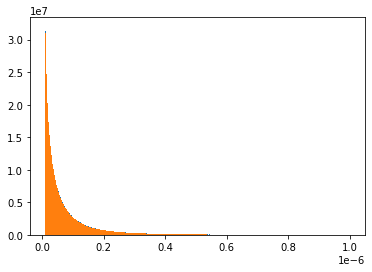

In [58]:
binEdges = np.logspace(-8,-6,num=1000)

histCLM5  = plt.hist(lndPRECT_clm5.reshape([len(lat)*len(lon)*np.shape(lndPRECT_clm5)[0]]), bins=binEdges, density=True)
histCLM45 = plt.hist(lndPRECT_clm45.reshape([len(lat)*len(lon)*np.shape(lndPRECT_clm45)[0]]), bins=binEdges, density=True)

plt.show()



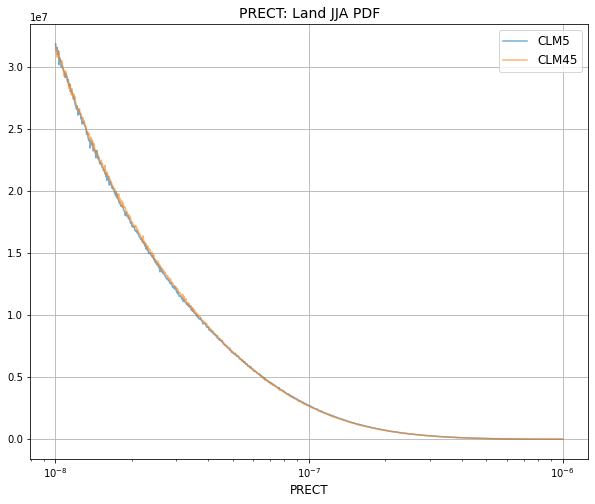

In [60]:
binWidth  = (binEdges[1]-binEdges[0])/2
binCenters = binEdges[1::]-binWidth

fig, ax1 = plt.subplots(1,1, figsize=(10, 8))

ax1.semilogx(binCenters, histCLM5[0], label='CLM5', alpha=0.6)
ax1.semilogx(binCenters, histCLM45[0], label='CLM45', alpha=0.6)

ax1.set_title('PRECT: Land JJA PDF',fontsize=14)
ax1.legend(fontsize=12)
ax1.set_xlabel('PRECT',fontsize=12)
ax1.grid()



**PRECT**

In [52]:
clm5_DSnoAnom_qt

<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, quantile: 3)
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * quantile  (quantile) float64 0.9 0.95 0.99
Data variables:
    TREFHT    (quantile, lat, lon) float64 222.6 222.6 222.6 ... 273.6 273.6
    TREFHTMN  (quantile, lat, lon) float64 220.8 220.8 220.8 ... 273.5 273.5
    TREFHTMX  (quantile, lat, lon) float64 224.6 224.6 224.6 ... 273.9 273.9
    PRECT     (quantile, lat, lon) float64 7.175e-09 7.175e-09 ... 5.844e-08

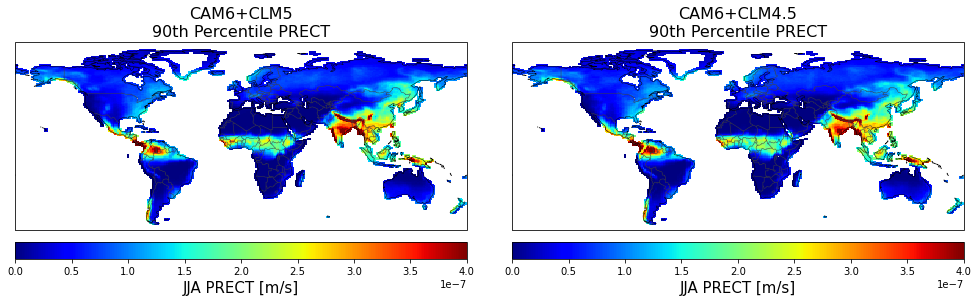

In [55]:
# Set up figure 
fig, axs = plt.subplots(1,2, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.5,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,clm5_DSnoAnom_qt.PRECT.values[0,:,:]*lndMask_notCyclic,
                                vmin = 0, vmax = 4e-7, 
                                 cmap='jet')
# Add colorbars 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA PRECT [m/s]',fontsize=15)


contour_plot = axs[1].pcolormesh(lon,lat,clm45_DSnoAnom_qt.PRECT.values[0,:,:]*lndMask_notCyclic,
                                 vmin = 0, vmax = 4e-7,
                                 cmap='jet')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA PRECT [m/s]',fontsize=15)


# Additional options 
axs[0].set_title('CAM6+CLM5\n90th Percentile PRECT',fontsize=16)
axs[1].set_title('CAM6+CLM4.5\n90th Percentile PRECT',fontsize=16)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


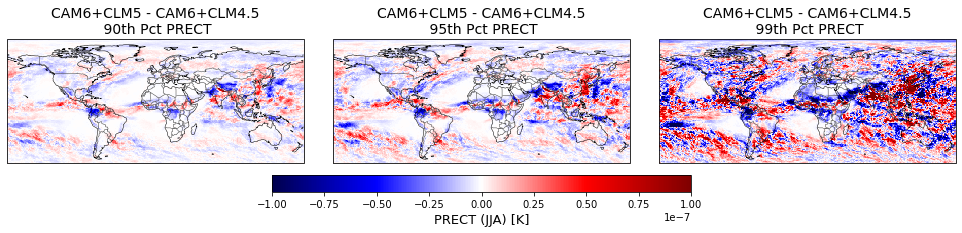

In [58]:
# Set up figure 
fig, axs = plt.subplots(1,3, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.5,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,clm5_DSnoAnom_qt.PRECT.values[0,:,:] - clm45_DSnoAnom_qt.PRECT.values[0,:,:],
                                 vmax = 1e-7, vmin = -1e-7,
                                 cmap='seismic')

contour_plot = axs[1].pcolormesh(lon,lat,clm5_DSnoAnom_qt.PRECT.values[1,:,:] - clm45_DSnoAnom_qt.PRECT.values[1,:,:],
                                 vmax = 1e-7, vmin = -1e-7,
                                 cmap='seismic')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.05, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('PRECT (JJA) [K]',fontsize=13)

contour_plot = axs[2].pcolormesh(lon,lat,clm5_DSnoAnom_qt.PRECT.values[2,:,:] - clm45_DSnoAnom_qt.PRECT.values[2,:,:],
                                 vmax = 1e-7, vmin = -1e-7,
                                 cmap='seismic')


# Additional options 
axs[0].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 90th Pct PRECT',fontsize=14)
axs[1].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 95th Pct PRECT',fontsize=14)
axs[2].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 99th Pct PRECT',fontsize=14)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



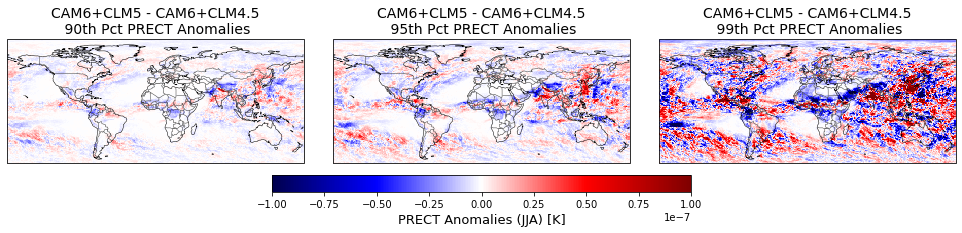

In [59]:
# Set up figure 
fig, axs = plt.subplots(1,3, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.5,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,clm5_DS_qt.PRECT.values[0,:,:] - clm45_DS_qt.PRECT.values[0,:,:],
                                 vmax = 1e-7, vmin = -1e-7,
                                 cmap='seismic')

contour_plot = axs[1].pcolormesh(lon,lat,clm5_DS_qt.PRECT.values[1,:,:] - clm45_DS_qt.PRECT.values[1,:,:],
                                 vmax = 1e-7, vmin = -1e-7,
                                 cmap='seismic')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.05, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('PRECT Anomalies (JJA) [K]',fontsize=13)

contour_plot = axs[2].pcolormesh(lon,lat,clm5_DS_qt.PRECT.values[2,:,:] - clm45_DS_qt.PRECT.values[2,:,:],
                                 vmax = 1e-7, vmin = -1e-7,
                                 cmap='seismic')


# Additional options 
axs[0].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 90th Pct PRECT Anomalies',fontsize=14)
axs[1].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 95th Pct PRECT Anomalies',fontsize=14)
axs[2].set_title('CAM6+CLM5 - CAM6+CLM4.5\n 99th Pct PRECT Anomalies',fontsize=14)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
